In [48]:
"""Create parameters.py and load it"""

# Directory for .inp file:
path = 'D:/parameter_studies/Bubble_dynamics_simulation/INP file examples/chemkin_AR_HE.inp'

# import libraries:
import importlib   # For reloading your own files
import numpy as np
# my own files:
import Bubble_dynamics_simulation.inp_data_extractor as inp   # numeric constants and coefficents
importlib.reload(inp)   # reload changes you made
inp.extract(path)

import parameters as par   # numeric constants and coefficents
importlib.reload(par)   # reload changes you made
print(par.model)

path=D:/parameter_studies/Bubble_dynamics_simulation/INP file examples/chemkin_AR_HE.inp
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'O' is not in data.py: 0.0 is used
Note, lambda value for specie 'OH' is not in data.py: 0.0 is used
Note, lambda value for specie 'HO2' is not in data.py: 0.0 is used
Note, lambda value for specie 'OHEX' is not in data.py: 0.0 is used
Warning, third body 'CO' is not in species in line 65 ('H2/2.5/ O2/1/ H2O/12/ CO/1.9/ CO2/3.8/ HE/0.83/ AR/1/') in reaction '2H+M=H2+M'
Warning, third body 'CO2' is not in species in line 65 ('H2/2.5/ O2/1/ H2O/12/ CO/1.9/ CO2/3.8/ HE/0.83/ AR/1/') in reaction '2H+M=H2+M'
Warning, third body 'CO' is not in species in line 67 ('H2/2.5/ H2O/12/ AR/0.83/ CO/1.9/ CO2/3.8/ HE/0.83/') in reaction '2O+M=O2+M'
Warning, third body 'CO2' is not in species in line 67 ('H2/2.5/ H2O/12/ AR/0.83/ CO/1.9/ CO2/3.8/ HE/0.83/') in reaction '2O+M=O2+M'
Warning, third body 'CO' is not in speci

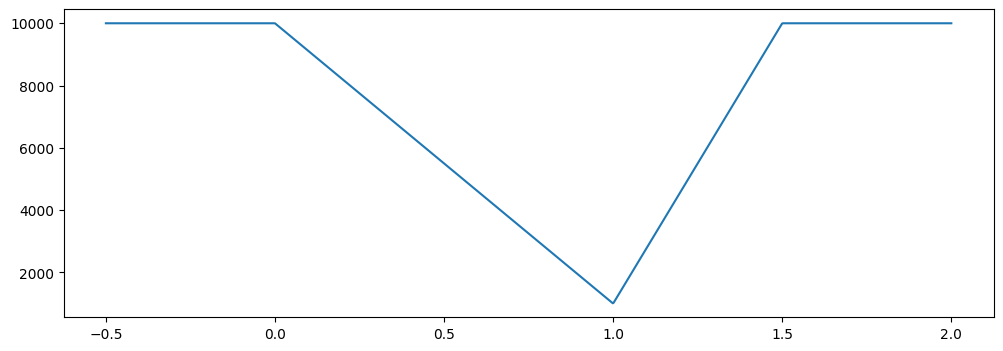

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from numba import njit   # Just In Time compiler
from numba.types import float64   # JIT types

@njit(float64(float64, float64, float64[:]))
def Excitation(t, P_amb, args):
    decay_time, increase_time, min_pressure, radius = args
    if t < 0.0:
        p_Inf = P_amb
    elif t > decay_time+increase_time:
        p_Inf = P_amb
    elif t < decay_time:
        p_Inf = P_amb - (P_amb-min_pressure) / decay_time * t
    else:
        p_Inf = min_pressure + (P_amb-min_pressure) / (increase_time) * (t-decay_time)
    return p_Inf#np.array([p_Inf, p_Inf_dot], dtype=np.float64)

def circle(t, args):
    radius, center_x, center_y = args
    return np.sqrt(radius**2 - (t-center_x)**2) + center_y

t = np.linspace(-0.5, 2.0, 1000)
args = np.array([1.0, 0.5, 1000, 0.1], dtype=np.float64); P_amb = 10000
p = [Excitation(time, P_amb, args) for time in t]
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(axisbelow=True)
ax.plot(t, p)


In [50]:
"""Import simulation"""

import numpy as np
import importlib
import matplotlib.pyplot as plt
from termcolor import colored

already_imported = 'de' in globals()
try:
    import full_bubble_model as de
except:
    try:
        import Bubble_dynamics_simulation.full_bubble_model as de
    except:
        print(colored(f'Error, \'full_bubble_model.py\' not found', 'red'))
if already_imported: importlib.reload(de)   # reload changes you made

model: chem_Otomo2018_without_O
target specie: NH3
excitation: sin_impulse (control parameters: ['p_A', 'freq', 'n'])
enable heat transfer: True	enable evaporation: False	enable reactions: True	enable dissipated energy: True


In [106]:
"""Control parameters"""

cpar = de.dotdict(dict(
    ID = 0,                           # ID of control parameter (not used during calculation)
  # Initial conditions:
    R_E = 5.0e-6,                    # bubble equilibrium radius [m]
    ratio = 1.0,                      # initial radius / equilibrium radius R_0/R_E [-]
    gases=[par.index['N2'], par.index['H2']],          # indexes of species in initial bubble (list of species indexes)
    fractions=[0.25, 0.75],                  # molar fractions of species in initial bubble (list of fractions for every gas)
  # Ambient parameters:
    P_amb = 1.0 * par.bar2Pa,         # ambient pressure [Pa]
    T_inf = 30.0 + par.absolute_zero, # ambient temperature [K]
  # Liquid parameters:
    alfa_M = 0.35,              # water accommodation coefficient [-]
    P_v = par.P_v,                    # vapour pressure [Pa]
    mu_L = par.mu_L,                  # dynamic viscosity [Pa*s]
    c_L = par.c_L,                    # sound speed [m/s]
    surfactant = 1.0,                 # surfactant (surface tension modfier) [-]
  # Excitation parameters: (excitation_type = sin_impulse_flat_ends)
    p_A = -1.5*1e5,                        # [Pa]
    freq = 30.0e3,                       # [Hz]
    n = 1.0,                          # [-]
))

# Calculate pressure/temperature dependent parameters:
cpar.mu_L = de.Viscosity(cpar.T_inf)
cpar.P_v = de.VapourPressure(cpar.T_inf)

"""# Equilibrium state
p_E = cpar.P_amb + 2.0 * cpar.surfactant * par.sigma / cpar.R_E # [Pa]
V_E = 4.0 / 3.0 * cpar.R_E**3 * np.pi # [m^3]
p_gas = p_E - cpar.P_v  # [Pa]
n_gas = p_gas * V_E / (par.R_g * cpar.T_inf) # [mol]

# Expansion
R_0 = cpar.R_E * 4.5
V_0 = 4.0 / 3.0 * R_0**3 * np.pi    # [m^3]
n_H2O = cpar.P_v * V_0 / (par.R_g * cpar.T_inf) # [mol]
c_H2O = n_H2O / V_0    # [mol/m^3]
c_gas = n_gas / V_0    # [mol/m^3]
p_gas = c_gas * par.R_g * cpar.T_inf # [Pa]
cpar.min_pressure = cpar.P_amb#cpar.P_v + p_gas - 2.0 * cpar.surfactant * par.sigma / R_0"""
None

succecfully solved with LSODA solver


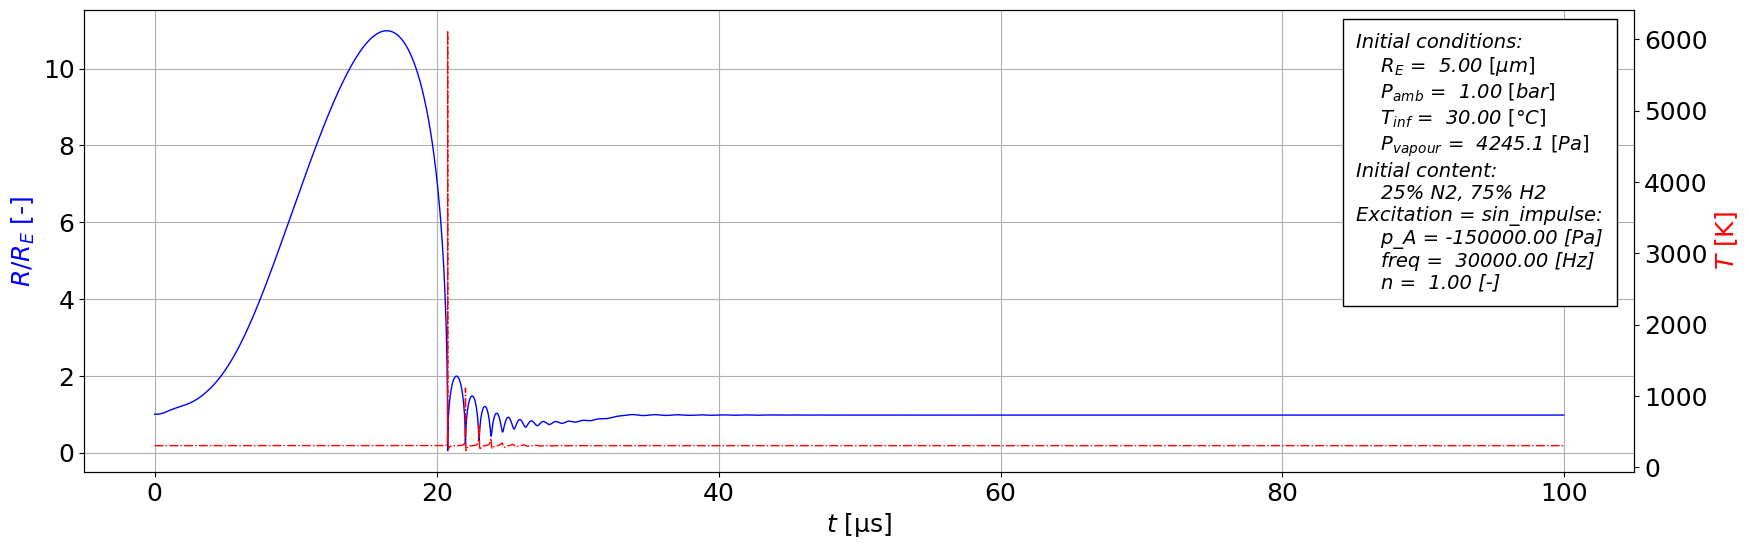

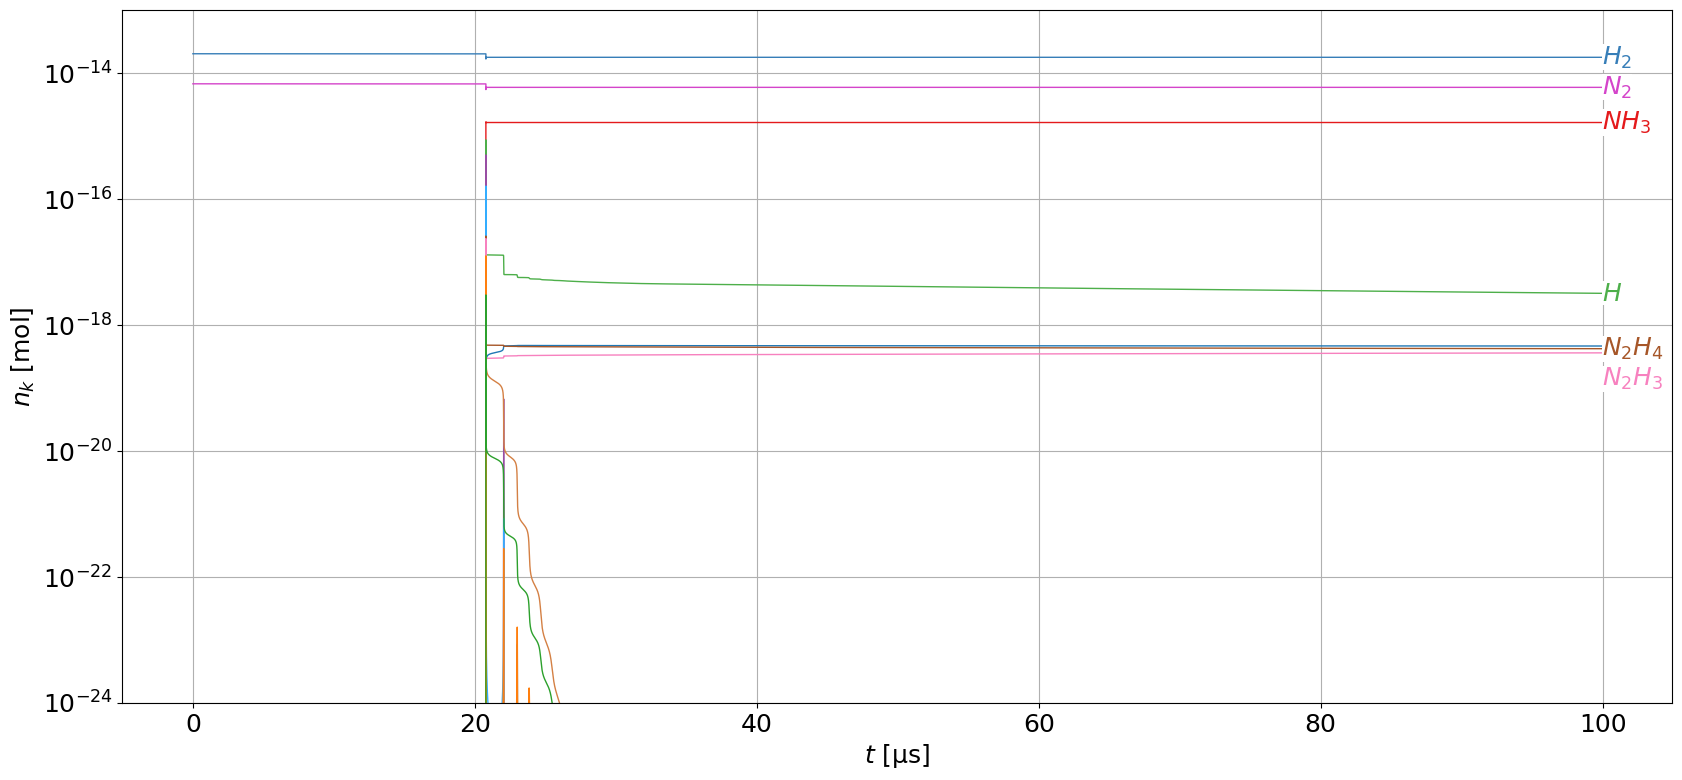

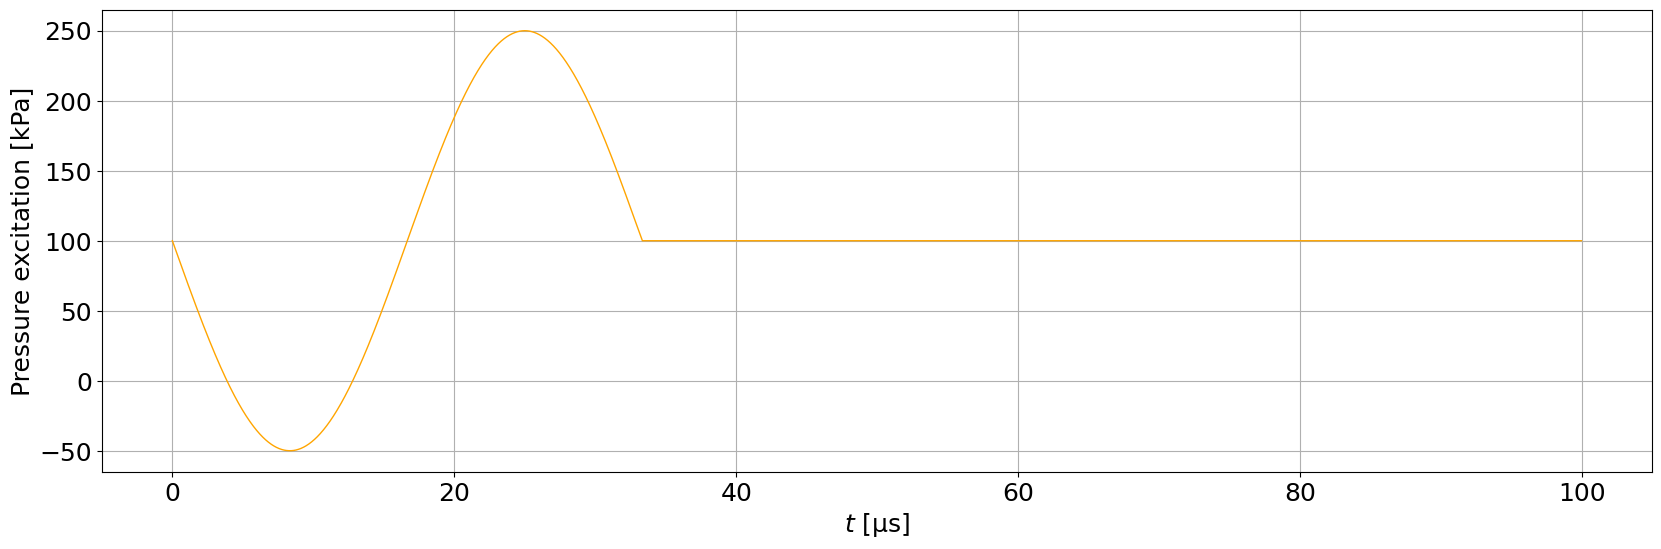

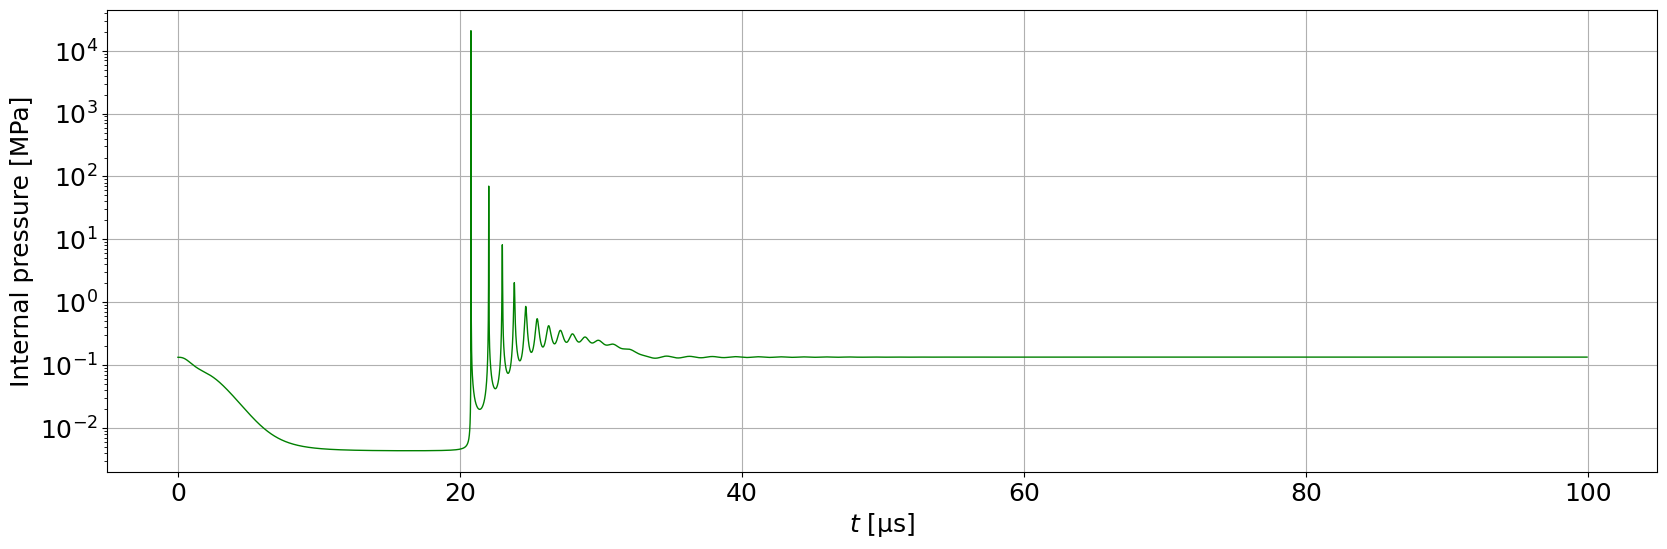

Control parameters:
    ID = 0
    R_E = 5.00 [um]
    ratio = 1.00 [-]
    P_amb = 1.00 [bar]
    alfa_M = 0.35 [-]
    T_inf = 30.00 [°C]
    P_v = 4245.13 [Pa]
    mu_L = 0.81 [mPa*s]
    surfactant = 1.00 [-]    
    excitation = 'sin_impulse'
    (p_A =-150000.00 [Pa]; freq = 30000.00 [Hz]; n = 1.00 [-])
    Initial content: 25% N2, 75% H2
Simulation info:
    error_code = 0
    elapsed_time = 1.22 [s]
    steps = 15469 [-]
Final state:
    R_final = 4.89 [um];   R_dot_final =4.20353713095442e-06 [m/s];   T_final = 303.15 [K]
    n_NH3_final = 1.63e-15 [mol]
    Final molar concentrations: [mol/cm^3]
        NH3   :   3.3216683637212918e-06;    H2    :   3.6019389812741644e-05;    H     :    6.449679001331641e-09;    NH2   :   1.0701035845721366e-22;    
        NH    :   2.3918116214767708e-23;    N     :    9.401094943227207e-10;    NNH   :    3.431608292174614e-19;    N2H4  :    8.522366799988081e-10;    
        N2H3  :    7.319988796731714e-10;    N2H2  :   2.1282317913695611

In [107]:
"""Plotting"""
#importlib.reload(de)   # reload changes you made
de.plot(cpar, t_int=[0.0, 3.0/cpar.freq], presentation_mode=False, plot_pressure=True, LSODA_timeout=30, Radau_timeout=0)